In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

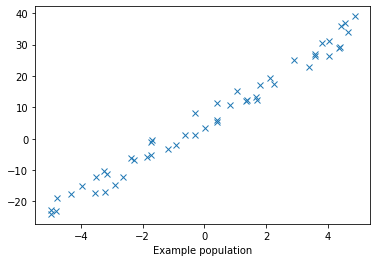

In [2]:
#Number of data points
n = 50
X = np.random.uniform(-5, 5, n) 
error = np.random.uniform(0, 8, n) # Gaussian distribution

#This are the real parameters
true_beta1, true_beta0 = 6, 2

#Our true function
# y = beta1 * x + beta0 + ε
y = true_beta1 * X + true_beta0 + error

pop = np.array([X, y])

plt.plot(X, y, 'x');
plt.xlabel('Example population')
plt.show()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
w = torch.zeros([1, 2], dtype=torch.float32, requires_grad=True)

def forward(x):
    return torch.matmul(w, x)

In [5]:
#Prepare training samples
X_tensor =  torch.from_numpy(X).float()
X_tensor = torch.cat((X_tensor, torch.ones(50)))
X_tensor = torch.reshape(X_tensor, (2, -1))

y_tensor = torch.from_numpy(y).float()
y_tensor = torch.reshape(y_tensor, (1, -1))

### Train model

In [6]:
n_epoch = 100
lr = 0.01

optimizer = optimizer = torch.optim.SGD([w], lr=lr)
loss = torch.nn.MSELoss()

for epoch in range(n_epoch):
    
    optimizer.zero_grad()
    
    out = forward(X_tensor)
    
    error = loss(out, y_tensor)
    
    error.backward()
    
    optimizer.step()

In [7]:
print(f'Parameters b1: {w[0][1].item()}, b0: {w[0][0].item()}')

Parameters b1: 5.078518390655518, b0: 5.873547077178955


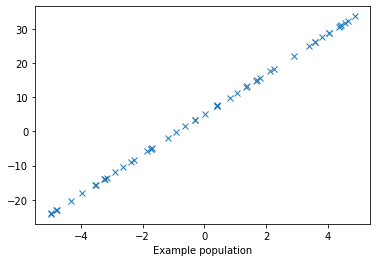

In [8]:
#Our true function
# y = beta1 * x + beta0 + ε
y_hat = w[0][0].item() * X + w[0][1].item()

pop = np.array([X, y])

plt.plot(X, y_hat, 'x');
plt.xlabel('Example population')
plt.show()

### When gradients are calculated?

In [9]:
#reset weights
lr = 0.01
w = torch.zeros([1, 2], dtype=torch.float32, requires_grad=True)
optimizer = optimizer = torch.optim.SGD([w], lr=lr)

In [10]:
print(f'Before training: {w.grad} parameters: {w}')

out = forward(X_tensor)

print(f'After first forward pass: {w.grad} parameters: {w}')

error = loss(out, y_tensor)

print(f'After error calculation: {w.grad} parameters: {w}')

error.backward()

print(f'After backward: {w.grad} parameters: {w}')

optimizer.step()

print(f'After optimizer step: {w.grad} parameters: {w}')

optimizer.zero_grad()

print(f'After optimizer zero grad: {w.grad} parameters: {w}')

Before training: None parameters: tensor([[0., 0.]], requires_grad=True)
After first forward pass: None parameters: tensor([[0., 0.]], requires_grad=True)
After error calculation: None parameters: tensor([[0., 0.]], requires_grad=True)
After backward: tensor([[-110.7970,  -12.4580]]) parameters: tensor([[0., 0.]], requires_grad=True)
After optimizer step: tensor([[-110.7970,  -12.4580]]) parameters: tensor([[1.1080, 0.1246]], requires_grad=True)
After optimizer zero grad: tensor([[0., 0.]]) parameters: tensor([[1.1080, 0.1246]], requires_grad=True)


Gradients are calculated after error.backward function.
Parameters are updated when usin optimizer.step.
Gradients are set to 0 using optimizar.zero_grad funcion.

#### Divide training into two chunks, use forward separatly on each chunk and check how gradients and parameters behave

In [34]:
#reset weights
lr = 0.01
w = torch.zeros([1, 2], dtype=torch.float32, requires_grad=True)
optimizer = optimizer = torch.optim.SGD([w], lr=lr)

In [35]:
#separate X_tensor
X1 = X_tensor[:, :25]
X2 = X_tensor[:, 25:]
y1 = y_tensor[:, :25]
y2 = y_tensor[:, 25:]

print(f'Before training 1: {w.grad} parameters: {w}')

out = forward(X1)
error1 = loss(out, y1)
error1.backward()

print(f'After backward 1: {w.grad} parameters: {w}')

out = forward(X2)
error2 = loss(out, y2)
error2.backward()

print(f'After backward 2: {w.grad} parameters: {w}')

optimizer.step()

print(f'After optimizer step: {w.grad} parameters: {w}')

optimizer.zero_grad()

Before training 1: None parameters: tensor([[0., 0.]], requires_grad=True)
After backward 1: tensor([[-126.0480,  -13.9361]]) parameters: tensor([[0., 0.]], requires_grad=True)
After backward 2: tensor([[-221.5941,  -24.9161]]) parameters: tensor([[0., 0.]], requires_grad=True)
After optimizer step: tensor([[-221.5941,  -24.9161]]) parameters: tensor([[2.2159, 0.2492]], requires_grad=True)


Gradients calculated in the first backward pass are summed up with gradients calculated with second backward pass.
When using this approach at least with this example, it seems to be converging quickly, why?, perhaps because using a smaller training sample each time derives in calculating bigger gradients thus converging faster.

In [36]:
#reset weights
lr = 0.01
w = torch.zeros([1, 2], dtype=torch.float32, requires_grad=True)
optimizer = optimizer = torch.optim.SGD([w], lr=lr)

In [37]:
#separate X_tensor
X1 = X_tensor[:, :25]
X2 = X_tensor[:, 25:]
y1 = y_tensor[:, :25]
y2 = y_tensor[:, 25:]

print(f'Before training 1: {w.grad} parameters: {w}')

out = forward(X2)
error1 = loss(out, y2)
error1.backward()

print(f'After backward 1: {w.grad} parameters: {w}')

out = forward(X1)
error2 = loss(out, y1)
error2.backward()

print(f'After backward 2: {w.grad} parameters: {w}')

optimizer.step()

print(f'After optimizer step: {w.grad} parameters: {w}')

optimizer.zero_grad()

Before training 1: None parameters: tensor([[0., 0.]], requires_grad=True)
After backward 1: tensor([[-95.5461, -10.9799]]) parameters: tensor([[0., 0.]], requires_grad=True)
After backward 2: tensor([[-221.5941,  -24.9161]]) parameters: tensor([[0., 0.]], requires_grad=True)
After optimizer step: tensor([[-221.5941,  -24.9161]]) parameters: tensor([[2.2159, 0.2492]], requires_grad=True)


If chunk 2 is trained first, and then chunk 1, we end up with the same gradients.